In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import model_selection, preprocessing, linear_model, neighbors, ensemble, tree, neural_network, metrics, impute
from sklearn.pipeline import Pipeline

from utils import classification_util as cu
from utils import data_preprocessing_util as dpu

from copy import deepcopy

In [3]:
data_path = r'data/Fertility/fertility_diagnosis.csv'
df = pd.read_csv(data_path)
# rename some variables, change the original dataset encoding
df = dpu.preprocess_fertility_dataset(df)

# Data exploration

Dataset is heavily imbalanced:

[Text(0, 0, '0.88'), Text(0, 0, '0.12')]

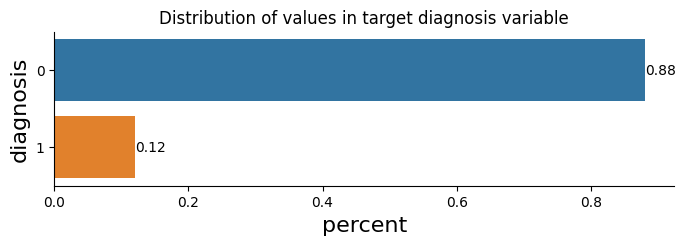

In [10]:
class_counts = df['diagnosis'].value_counts()/len(df['diagnosis'])
_, ax = plt.subplots(figsize=(8, 2))
sns.despine()
b = sns.barplot(x=class_counts.values, y=class_counts.index.astype(str))
ax.set(title='Distribution of values in target diagnosis variable')
b.set_xlabel('percent', fontsize=16)
b.set_ylabel('diagnosis', fontsize=16)
ax.bar_label(ax.containers[0], fmt='{:.2f}')

Ratio variables are more or less normally distributed:

/var/folders/tc/kb5gq8ms7xv2tdf3j0y_5yzh0000gn/T/ipykernel_17207/1839174877.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  b.set_yticklabels([str(i) for i in b.get_yticks()], fontsize = 14)


Text(0.5, 1.0, 'Distribution of age')

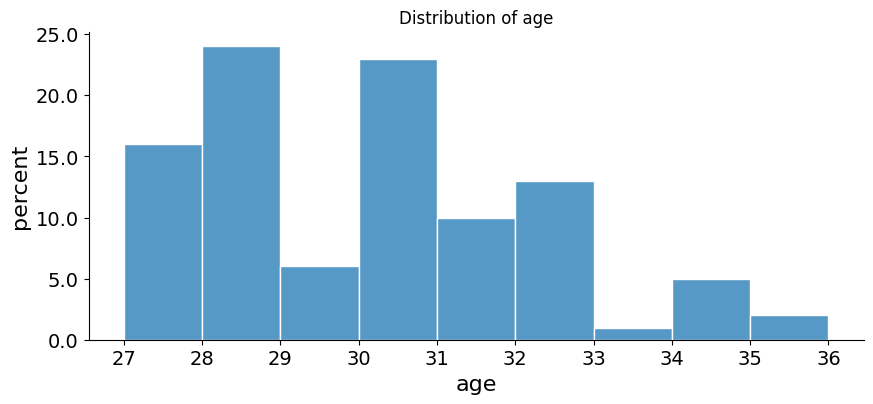

In [11]:
_, ax = plt.subplots(figsize=(10, 4))
sns.despine()
b = sns.histplot(df, x=df.age.astype(int), ax=ax, edgecolor='white', stat='percent', bins=9)
b.set_xlabel('age', fontsize=16)
b.set_ylabel('percent', fontsize=16)
ax.set_xticks(range(27, 37), labels=range(27, 37), fontsize=14)
b.set_yticklabels([str(i) for i in b.get_yticks()], fontsize = 14)
ax.set_title('Distribution of age')

/var/folders/tc/kb5gq8ms7xv2tdf3j0y_5yzh0000gn/T/ipykernel_17207/529603228.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  b.set_yticklabels([str(i) for i in b.get_yticks()], fontsize = 14)


[Text(0.5, 1.0, 'Distribution of number of hours spent sitting per day'),
 Text(0.5, 0, 'hours sitting per day')]

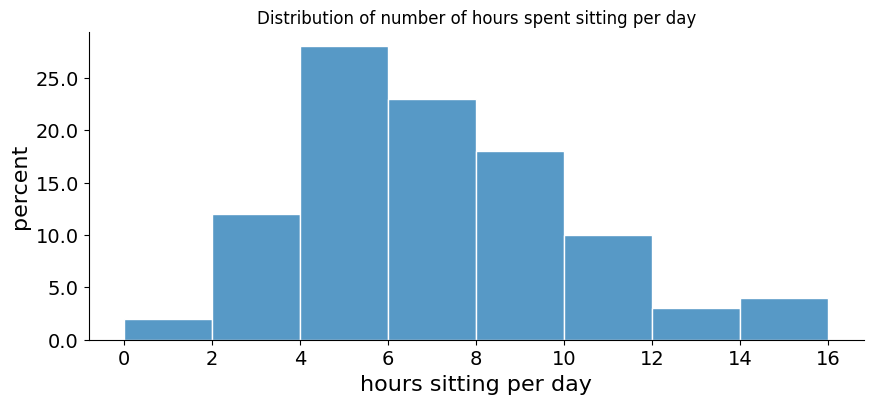

In [12]:
_, ax = plt.subplots(figsize=(10, 4))
sns.despine()
b = sns.histplot(df, x='hours_sitting', ax=ax, edgecolor='white', stat='percent', bins=range(0,18,2))
b.set_xlabel('hours spent sitting per day', fontsize=16)
b.set_ylabel('percent', fontsize=16)
ax.set_xticks(range(0, 18, 2), labels=range(0, 18, 2), fontsize=14)
b.set_yticklabels([str(i) for i in b.get_yticks()], fontsize = 14)
ax.set(title='Distribution of number of hours spent sitting per day', xlabel='hours sitting per day')

Dataset does not contain any missing values:

In [4]:
na_counts = df.isna().sum() / len(df)
print(f'Columns with missing values: {na_counts[na_counts > 0.0]}')

Columns with missing values: Series([], dtype: float64)


# Data preprocessing

Only 2 variables in the dataset are ratio and both are normally distributed (see the fertility_dataset_exploration.ipynb notebook or report from Exercise 0), so they don't need to be transformed. Other variables are categorical, so they need to be encoded.

Season variable should definitely be encoded with 1-hot encoding. Regarding other variables: high_fever, alcohol_consumption, smoking, which contain frequency information (daily, occasional etc.), we are not so sure. On one hand, it definitely has an ordering, so label encoding might be an option. On the other hand, the freuqencies are not equidistant. For these 3 variables, we decided to try out both encodings and see how it influences the algorithm's performance.

Example of possible frequency values in df.smoking:

In [14]:
df.smoking.unique()

array(['occasional', 'daily', 'never'], dtype=object)

Dataset is highly imbalanced:

In [ ]:
df.diagnosis.value_count()

# 2. Classification

In [5]:
df_original = df.copy()

In [6]:
random_seed = 1038
encoding = 'one-hot'
scaling = True
oversampling = True
holdout = True

scaler = preprocessing.StandardScaler() if scaling else None

In [7]:
df = dpu.encode(df=df_original, encoding=encoding)

y = df['diagnosis']
X = df[df.columns.difference(['diagnosis'])]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = random_seed, shuffle=True, stratify=y)

if holdout:
    X_tr, _, _, _ = model_selection.train_test_split(X_train, y_train, test_size = 0.2, random_state = random_seed, shuffle=True, stratify=y_train)
    
    tr_val_split = y_train.copy()
    tr_val_split[:] = 0
    tr_val_split[X_tr.index.values] = -1
    
    cv = model_selection.PredefinedSplit(tr_val_split)

In [8]:
methods = [
    ('KNN', neighbors.KNeighborsClassifier()), 
    ('DT', tree.DecisionTreeClassifier()), 
    ('MLP', neural_network.MLPClassifier())
    ]
    
pipelines = cu.define_pipelines(methods, scaler=scaler, oversampling=oversampling)

params = {}
params['KNN'] = {
    'KNN__n_neighbors' : [5, 10, 25, 50], 
    'KNN__p' : [1, 2]
}
params['DT'] = {
    'DT__criterion': ['gini', 'entropy', 'log_loss'],
    'DT__splitter': ['best', 'random'],
    'DT__class_weight': [None, 'balanced'],
    'DT__random_state': [random_seed],
}
params['MLP'] = {
    'MLP__hidden_layer_sizes': [(10,), (10, 10), (20), (20, 20,)], 
    'MLP__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'MLP__solver': ['lbfgs', 'adam', 'sgd'],
    'MLP__alpha': [0.001, 0.0001],
    'MLP__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'MLP__max_iter': [1000],
    'MLP__random_state': [random_seed],
}

### CV

In [86]:
model_cv = cu.compare_models(pipelines, params, X_train, y_train, X_test, y_test)

KNN
Best params: {'KNN__n_neighbors': 5, 'KNN__p': 1, 'KNN__weights': 'distance'}
Best score: 0.6006837606837607
Refit time: 0.004281044006347656
Evaluation metrics:


array([[0.66666667, 0.33333333],
       [0.5       , 0.5       ]])

acc: 0.65
balanced_acc: 0.5833333333333333

Macro-averaged precision: 0.532967032967033
Macro-averaged recall: 0.5833333333333333
Macro-averaged f-score: 0.4982078853046595
Macro-averaged support: None
Report line: 0.650 0.583 0.533 0.583 0.498 0.004 
----------------------------------------------------------------------------------------------------
DT
Best params: {'DT__class_weight': None, 'DT__criterion': 'entropy', 'DT__random_state': 1038, 'DT__splitter': 'best'}
Best score: 0.5493040293040293
Refit time: 0.006093740463256836
Evaluation metrics:


array([[0.83333333, 0.16666667],
       [1.        , 0.        ]])

acc: 0.75
balanced_acc: 0.4166666666666667

Macro-averaged precision: 0.4411764705882353
Macro-averaged recall: 0.4166666666666667
Macro-averaged f-score: 0.42857142857142855
Macro-averaged support: None
Report line: 0.750 0.417 0.441 0.417 0.429 0.006 
----------------------------------------------------------------------------------------------------
MLP


/Users/godlinn/opt/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [9]:
model_holdout = cu.compare_models(pipelines, params, X_train, y_train, X_test, y_test, cv)


KNN
Best params: {'KNN__n_neighbors': 25, 'KNN__p': 1, 'KNN__weights': 'uniform'}
Best score: 0.6135265700483092
Refit time: 0.004650115966796875
Evaluation metrics:


array([[0.5, 0.5],
       [0.5, 0.5]])

acc: 0.5
balanced_acc: 0.5

Macro-averaged precision: 0.5
Macro-averaged recall: 0.5
Macro-averaged f-score: 0.40476190476190477
Macro-averaged support: None
Report line: 0.500 0.500 0.500 0.500 0.405 0.005 
----------------------------------------------------------------------------------------------------
DT
Best params: {'DT__class_weight': None, 'DT__criterion': 'gini', 'DT__random_state': 1038, 'DT__splitter': 'best'}
Best score: 1.0
Refit time: 0.010036945343017578
Evaluation metrics:


array([[0.83333333, 0.16666667],
       [0.5       , 0.5       ]])

acc: 0.8
balanced_acc: 0.6666666666666667

Macro-averaged precision: 0.59375
Macro-averaged recall: 0.6666666666666667
Macro-averaged f-score: 0.6078431372549019
Macro-averaged support: None
Report line: 0.800 0.667 0.594 0.667 0.608 0.010 
----------------------------------------------------------------------------------------------------
MLP


/Users/godlinn/opt/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/godlinn/opt/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/godlinn/opt/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/godlinn/opt/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converge

Best params: {'MLP__activation': 'tanh', 'MLP__alpha': 0.001, 'MLP__hidden_layer_sizes': (20, 20), 'MLP__learning_rate': 'constant', 'MLP__max_iter': 1000, 'MLP__random_state': 1038, 'MLP__solver': 'adam'}
Best score: 0.7142857142857143
Refit time: 0.518237829208374
Evaluation metrics:


array([[0.77777778, 0.22222222],
       [1.        , 0.        ]])

acc: 0.7
balanced_acc: 0.3888888888888889

Macro-averaged precision: 0.4375
Macro-averaged recall: 0.3888888888888889
Macro-averaged f-score: 0.411764705882353
Macro-averaged support: None
Report line: 0.700 0.389 0.438 0.389 0.412 0.518 
----------------------------------------------------------------------------------------------------


NameError: name 'model_cv' is not defined